# Bayes Classifier

In [3]:
import util
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

%matplotlib inline

In [4]:
def clamp_sample(x):
  x = np.minimum(x, 1)
  x = np.maximum(x, 0)
  return x

In [5]:
class BayesClassifier:
  def fit(self, X, Y):
    # assume classes are numbered 0...K-1
    self.K = len(set(Y))

    self.gaussians = []
    self.p_y = np.zeros(self.K)
    for k in range(self.K):
      Xk = X[Y == k]
      self.p_y[k] = len(Xk)
      mean = Xk.mean(axis=0) # describe gaussian
      cov = np.cov(Xk.T) # describe gaussian
      g = {'m': mean, 'c': cov}
      self.gaussians.append(g)
    # normalize p(y)
    self.p_y /= self.p_y.sum()

  def sample_given_y(self, y):
    g = self.gaussians[y]
    return clamp_sample( mvn.rvs(mean=g['m'], cov=g['c']) )

  def sample(self):
    y = np.random.choice(self.K, p=self.p_y)
    return clamp_sample( self.sample_given_y(y) )

In [6]:
X, Y = util.get_mnist()
clf = BayesClassifier()
clf.fit(X, Y)

Reading in and transforming data...


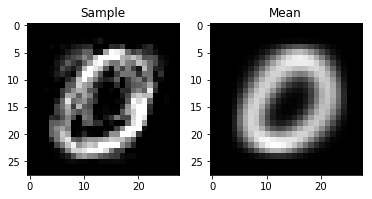

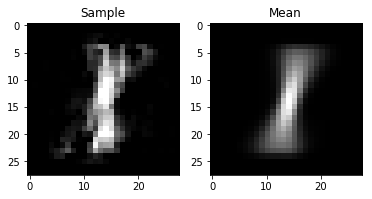

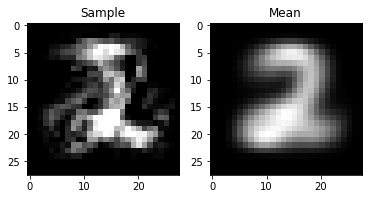

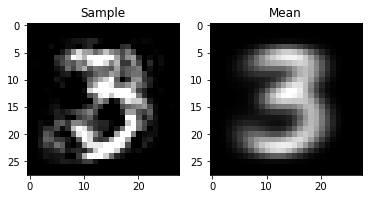

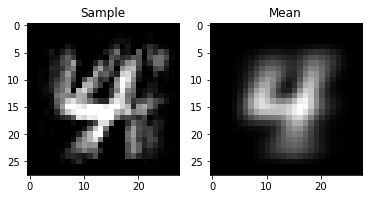

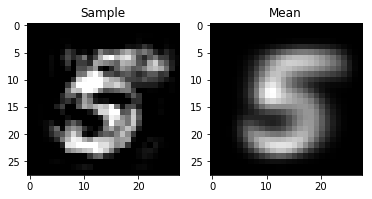

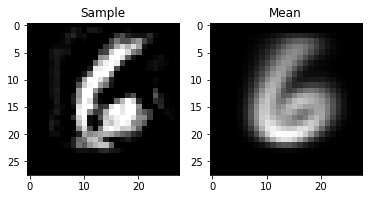

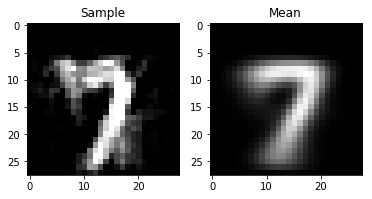

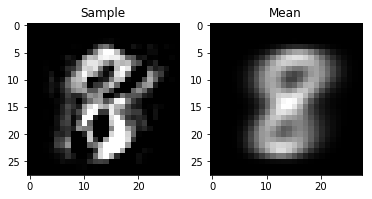

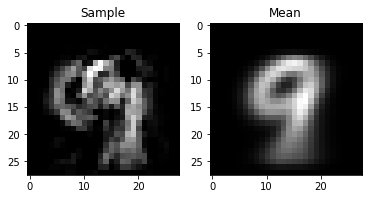

In [8]:
for k in range(clf.K):
# show one sample for each class
# also show the mean image learned from Gaussian Bayes Classifier

    sample = clf.sample_given_y(k).reshape(28, 28)
    mean = clf.gaussians[k]['m'].reshape(28, 28)

    plt.subplot(1,2,1)
    plt.imshow(sample, cmap='gray')
    plt.title("Sample")
    plt.subplot(1,2,2)
    plt.imshow(mean, cmap='gray')
    plt.title("Mean")
    plt.show()

# Bayes Classifier with Gaussian Mixture Models

In [14]:
from sklearn.mixture import BayesianGaussianMixture

In [12]:
class BayesClassifier:
  def fit(self, X, Y):
    # assume classes are numbered 0...K-1
    self.K = len(set(Y))

    self.gaussians = []
    self.p_y = np.zeros(self.K)
    for k in range(self.K):
      print("Fitting gmm", k)
      Xk = X[Y == k]
      self.p_y[k] = len(Xk)
      gmm = BayesianGaussianMixture(10) # number of clusters
      gmm.fit(Xk)
      self.gaussians.append(gmm)
    # normalize p(y)
    self.p_y /= self.p_y.sum()

  def sample_given_y(self, y):
    gmm = self.gaussians[y]
    sample = gmm.sample()
    # note: sample returns a tuple containing 2 things:
    # 1) the sample
    # 2) which cluster it came from
    # we'll use (2) to obtain the means so we can plot
    # them like we did in the previous script
    # we cheat by looking at "non-public" params in
    # the sklearn source code
    mean = gmm.means_[sample[1]]
    return clamp_sample( sample[0].reshape(28, 28) ), mean.reshape(28, 28)

  def sample(self):
    y = np.random.choice(self.K, p=self.p_y)
    return clamp_sample( self.sample_given_y(y) )

In [15]:
clf = BayesClassifier()
clf.fit(X, Y)

Fitting gmm 0
Fitting gmm 1
Fitting gmm 2
Fitting gmm 3
Fitting gmm 4
Fitting gmm 5
Fitting gmm 6
Fitting gmm 7
Fitting gmm 8
Fitting gmm 9


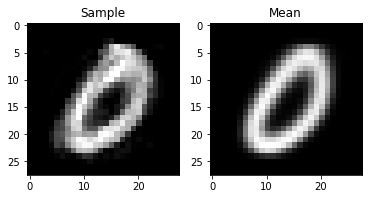

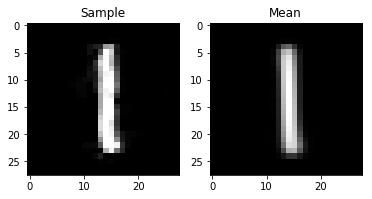

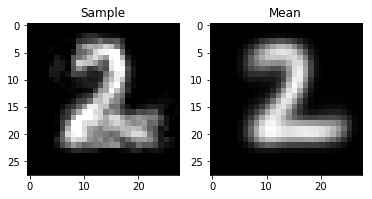

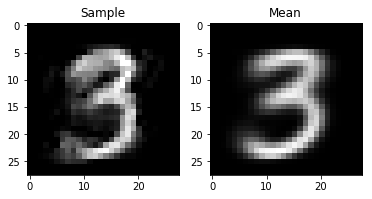

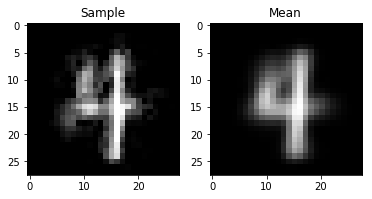

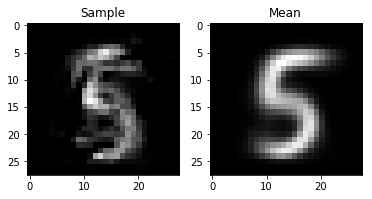

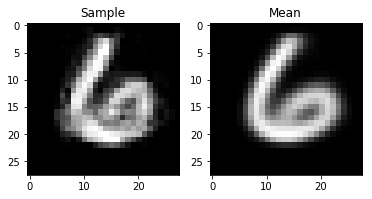

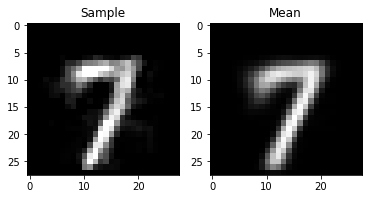

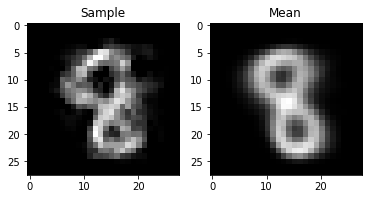

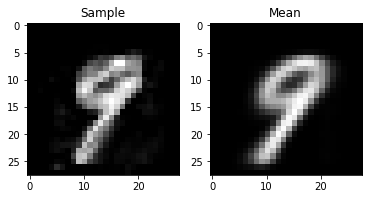

In [16]:
for k in range(clf.K):
# show one sample for each class
# also show the mean image learned

    sample, mean = clf.sample_given_y(k)

    plt.subplot(1,2,1)
    plt.imshow(sample, cmap='gray')
    plt.title("Sample")
    plt.subplot(1,2,2)
    plt.imshow(mean, cmap='gray')
    plt.title("Mean")
    plt.show()

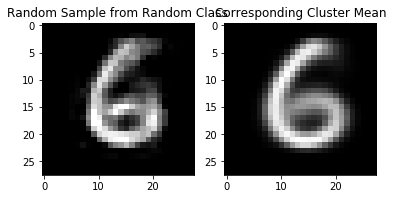

In [17]:
# generate a random sample
sample, mean = clf.sample()
plt.subplot(1,2,1)
plt.imshow(sample, cmap='gray')
plt.title("Random Sample from Random Class")
plt.subplot(1,2,2)
plt.imshow(mean, cmap='gray')
plt.title("Corresponding Cluster Mean")
plt.show()

# Neural Network and Autoencoder

In [18]:
import tensorflow as tf

In [33]:
class Autoencoder:
  def __init__(self, D, M):
    # represents a batch of training data
    self.X = tf.placeholder(tf.float32, shape=(None, D))

    # input -> hidden
    self.W = tf.Variable(tf.random_normal(shape=(D, M)) * np.sqrt(2.0 / M))
    self.b = tf.Variable(np.zeros(M).astype(np.float32))

    # hidden -> output
    self.V = tf.Variable(tf.random_normal(shape=(M, D)) * np.sqrt(2.0 / D))
    self.c = tf.Variable(np.zeros(D).astype(np.float32))

    # construct the reconstruction
    self.Z = tf.nn.relu(tf.matmul(self.X, self.W) + self.b)
    logits = tf.matmul(self.Z, self.V) + self.c
    self.X_hat = tf.nn.sigmoid(logits)

    # compute the cost
    self.cost = tf.reduce_sum(
      tf.nn.sigmoid_cross_entropy_with_logits(
        labels=self.X,
        logits=logits
      )
    )

    # make the trainer
    self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(self.cost)

    # set up session and variables for later
    self.init_op = tf.global_variables_initializer()
    self.sess = tf.InteractiveSession()
    self.sess.run(self.init_op)
    
  def fit(self, X, epochs=30, batch_sz=64):
    costs = []
    n_batches = len(X) // batch_sz
    print("n_batches:", n_batches)
    for i in range(epochs):
      if i % 5 == 0:
        print("epoch:", i)
      np.random.shuffle(X)
      for j in range(n_batches):
        batch = X[j*batch_sz:(j+1)*batch_sz]
        _, c, = self.sess.run((self.train_op, self.cost), feed_dict={self.X: batch})
        c /= batch_sz # just debugging
        costs.append(c)
        if (j % 100 == 0) and (i % 5 == 0):
            print("iter: %d, cost: %.3f" % (j, c))
    plt.plot(costs)
    plt.show()
    
  def predict(self, X):
    return self.sess.run(self.X_hat, feed_dict={self.X: X})

n_batches: 656
epoch: 0
iter: 0, cost: 556.776
iter: 100, cost: 116.676
iter: 200, cost: 92.653
iter: 300, cost: 79.293
iter: 400, cost: 71.079
iter: 500, cost: 66.773
iter: 600, cost: 63.363
epoch: 5
iter: 0, cost: 53.079
iter: 100, cost: 55.792
iter: 200, cost: 58.212
iter: 300, cost: 50.718
iter: 400, cost: 55.812
iter: 500, cost: 52.909
iter: 600, cost: 55.598
epoch: 10
iter: 0, cost: 52.137
iter: 100, cost: 52.782
iter: 200, cost: 52.657
iter: 300, cost: 52.161
iter: 400, cost: 52.250
iter: 500, cost: 51.924
iter: 600, cost: 52.588
epoch: 15
iter: 0, cost: 50.259
iter: 100, cost: 52.758
iter: 200, cost: 52.034
iter: 300, cost: 51.771
iter: 400, cost: 51.935
iter: 500, cost: 51.255
iter: 600, cost: 51.129
epoch: 20
iter: 0, cost: 52.164
iter: 100, cost: 52.326
iter: 200, cost: 51.630
iter: 300, cost: 52.303
iter: 400, cost: 51.917
iter: 500, cost: 51.300
iter: 600, cost: 51.685
epoch: 25
iter: 0, cost: 51.437
iter: 100, cost: 53.558
iter: 200, cost: 50.846
iter: 300, cost: 53.695
i

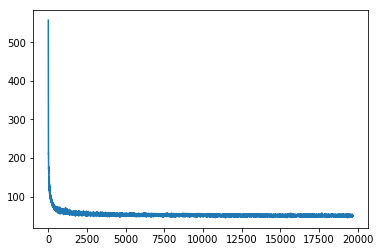

In [34]:
model = Autoencoder(784, 300)
model.fit(X)

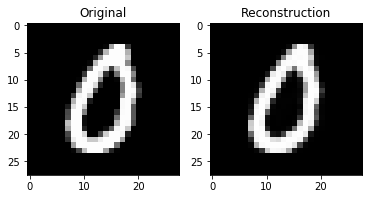

Generate another? Y


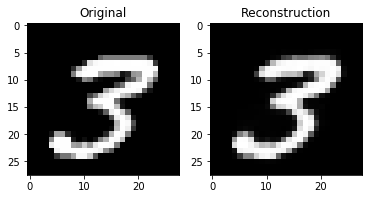

Generate another? Y


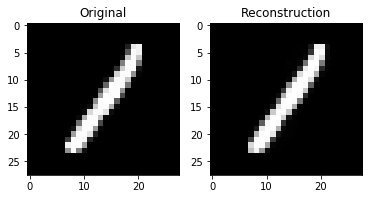

Generate another? Y


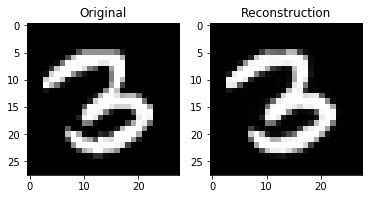

Generate another? n


In [36]:
done = False
while not done:
    i = np.random.choice(len(X))
    x = X[i]
    im = model.predict([x]).reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(im, cmap='gray')
    plt.title("Reconstruction")
    plt.show()

    ans = input("Generate another?")
    if ans and ans[0] in ('n' or 'N'):
      done = True